# Cardio Catch Disease Project

## Descrição do Problema

**A Empresa (ficticia)**
- A cardio Catch Disease é uma empresa especializada em detecção de doenças cardíacas em estágios iniciais. O modelo de negócio é do tipo Serviço, ou seja, a empresa oferece o diagnostico precoce de uma doença cardiovascular por um certo preço.


**Problema de Negócio**
- Atualmente o diagnostico é feito manualmente por uma equipe de especialistas. A precisão atual varia entre 55% a 65%, devido a complexidade do diagnostico e também da fadiga da equipe que se reveza em turnos para minimizar os riscos. O custo de cada diagnostico, incluindo os aparelhos e a folha de pagamento dos analistas gira em torno de R$1.000,00.

- O preço do diagnostico pago pelo cliente varia de acordo com a precisão conseguida pelo time de especialistas, o cliente paga R$500,00 a cada 5% de acurácia acima de 50%.


**Objetivo**
- Criar uma ferramenta que aumente a precisão do diagnóstico e que essa precisão seja estável para todos os diagnosticos.

**Perguntas para responder**
- Qual acurácia e precisão da ferramenta
- Quanto lucro a empresa passará a ter com a nova ferramenta
- Qual a confiabilidade do resultado dos dados pela nova ferramenta?

# 0.0. Imports

In [118]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import pickle

from scipy                   import stats
from IPython.display         import Image
from IPython.core.display    import HTML
from boruta                  import BorutaPy
from matplotlib              import pyplot        as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn                 import neighbors     as nh
from sklearn                 import metrics as m
from sklearn                 import linear_model  as lm
from sklearn                 import ensemble      as en
from lightgbm                import LGBMClassifier
from sklearn.model_selection import cross_val_score
from sklearn                 import preprocessing as pp
from sklearn.ensemble        import RandomForestRegressor, RandomForestClassifier, ExtraTreesClassifier

## 0.1. Helper Functions

In [102]:
def cross_validation( model_name, model, X, y ):
    
    cv_score = cross_val_score( model, X, y, cv=5, scoring='accuracy')
    cv_f1score = cross_val_score( model, X, y, cv=5, scoring='f1')
    cv_recall = cross_val_score( model, X, y, cv=5, scoring='recall')
    cv_precision = cross_val_score( model, X, y, cv=5, scoring='precision')
    cv_roc_auc = cross_val_score( model, X, y, cv=5, scoring='roc_auc')

    score_mean = round( np.mean( cv_score ), 3 )
    score_std = round( np.std( cv_score ), 3 )
    
    f1_mean = round( np.mean( cv_f1score ), 3 )
    f1_std = round( np.std( cv_f1score ), 3 )
    
    recall_mean = round( np.mean( cv_recall ), 3 )
    recall_std = round( np.std( cv_recall ), 3 )
    
    precision_mean = round( np.mean( cv_precision ), 3 )
    precision_std = round( np.std( cv_precision ), 3 )
    
    roc_auc_mean = round( np.mean( cv_roc_auc ), 3 )
    roc_auc_std = round( np.std( cv_roc_auc ), 3 )
    
    return pd.DataFrame( { 'Accuracy Score': ' {} +/- {} '.format( score_mean, score_std ),
                          'F1 Score': '{} +/- {}'.format( f1_mean, f1_std ),
                         'Recall Score': '{} +/- {}'.format( recall_mean, recall_std ),
                         'Precision Score': ' {} +/- {} '.format( precision_mean, precision_std ),
                         'ROC_AUC Score': ' {} +/- {} '.format( roc_auc_mean, roc_auc_std )}, index=[model_name] )





def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape

    chi2 = stats.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )

    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )



def highlight_max(data, color='green'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    #remove % and cast to float
    data = data.replace('%','', regex=True).astype(float)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)



# sets format to suppress scientific notation
pd.options.display.float_format = '{:,.6f}'.format

# sets seaborn default style
sns.set()

# sets global SEED
SEED = 28

## Loading Dataset

In [3]:
df_raw = pd.read_csv( '../data/raw/cardio_train.csv', sep=';')

# 1.0 Data Description

In [215]:
df1 = df_raw.copy()

## Spliting to take a test dataset

In [5]:
df1['cardio'].value_counts(normalize=True)

0   0.500300
1   0.499700
Name: cardio, dtype: float64

In [216]:
X = df1.drop( 'cardio', axis=1 )
y = df1['cardio'].copy()

x_training, x_test, y_training, y_test = train_test_split( X, y, test_size=0.1, random_state=28 )

df1 = pd.concat( [x_training, y_training], axis=1 )
df_test = pd.concat( [x_test, y_test ], axis=1 )

In [7]:
df_test['cardio'].value_counts(normalize=True)

0   0.501143
1   0.498857
Name: cardio, dtype: float64

In [8]:
df1['cardio'].value_counts(normalize=True)

0   0.500206
1   0.499794
Name: cardio, dtype: float64

## 1.1.Column Names 

In [9]:
df1.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

## 1.2. Data Dimensions

In [10]:
print('Number of Rows: {}'.format( df1.shape[0] ))
print('Number of Columns: {}'.format( df1.shape[1] ))

Number of Rows: 63000
Number of Columns: 13


## 1.3. Data Types

In [11]:
df1.dtypes

id               int64
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

## 1.4. Check NA

In [12]:
df1.isna().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

## 1.5. Descriptive Statistics

In [13]:
# Estatistica Descritiva
# Central Tendency - mean, median
ct1 = pd.DataFrame( df1.apply( np.mean ) ).T
ct2 = pd.DataFrame( df1.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( df1.apply( np.std ) ).T
d2 = pd.DataFrame( df1.apply( min ) ).T
d3 = pd.DataFrame( df1.apply( max ) ).T
d4 = pd.DataFrame( df1.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( df1.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( df1.apply( lambda x: x.kurtosis() ) ).T

# Concat
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,0.000000,"99,999.000000","99,999.000000","49,962.531063","49,938.500000","28,856.826649",0.000493,-1.199129
1,age,"10,798.000000","23,713.000000","12,915.000000","19,469.352032","19,703.000000","2,468.012245",-0.307221,-0.823181
2,gender,1.000000,2.000000,1.000000,1.350222,1.000000,0.477039,0.627962,-1.605715
3,height,55.000000,250.000000,195.000000,164.372841,165.000000,8.219944,-0.697752,8.629868
4,weight,10.000000,200.000000,190.000000,74.187552,72.000000,14.384827,1.017653,2.639800
5,ap_hi,-140.000000,"16,020.000000","16,160.000000",128.778683,120.000000,152.352806,85.856894,"7,698.285470"
6,ap_lo,-70.000000,"11,000.000000","11,070.000000",96.719048,80.000000,188.535871,31.770352,"1,398.122439"
7,cholesterol,1.000000,3.000000,2.000000,1.367857,1.000000,0.680265,1.582175,0.981197
8,gluc,1.000000,3.000000,2.000000,1.225952,1.000000,0.571583,2.401165,4.314433
9,smoke,0.000000,1.000000,1.000000,0.087762,0.000000,0.282948,2.913945,6.491281


1. **Age** is between 29 and 65
2. **Height** has suspicious values like 55cm and 250cm
3. **Weight** has very low values
4. **ap_hi** and **ap_lo** has negative values

# 2.0. Feature Engineering

In [14]:
df2 = df1.copy()

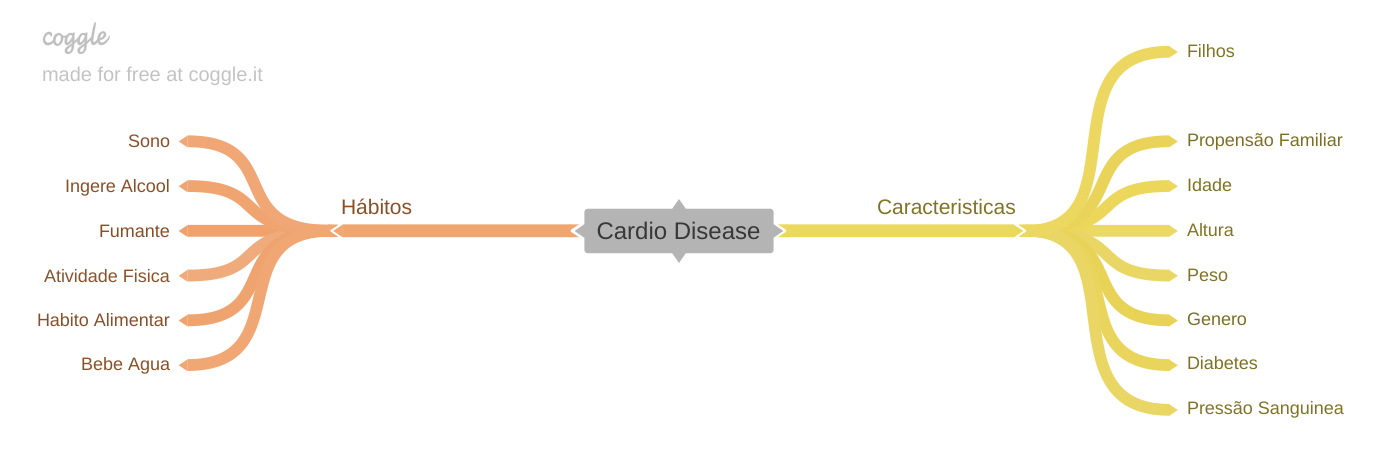

In [15]:
Image( 'C:/Users/Pedro/repos/cardio_diseases/cardio_catch_disease/img/cardio_disease.png' )

## Criação das Hipóteses

1. 50% das pessoas que fumam possuem doença cardiaca.
2. 80% das pessoas que praticam atividade fisica não possuem problemas cardiacos
3. Pessoas com imc elevado tendem a ter problemas cardiacos
4. Pessoas mais velhas tendem a ter problemas cardiacos.
5. Pessoas mais baixas tendem a ter problemas cardiacos.
6. Pessoas com habito alimentar ruim tendem a ter mais problemas cardiacos.
7. Pessoas com indice de colesterol mais altos tendem a ter problemas cardiacos.

## Feature Engineering

In [16]:
# Convertendo a coluna Age de dias para anos
df2['age'] = round(df2['age'] / 365)
df2['age'] = df2['age'].astype(np.int64)

In [17]:
# IMC
df2['imc'] = round( df2['weight'] / ( df2['height'] ** 2 ) * 10000, 2 )

In [18]:
# Assuming the average of normal IMC is 21.7, lets calculate de difference
df2['imc_diff'] = df2['imc'] - 21.7

In [19]:
# Sobrepeso
df2['sobrepeso'] = df2['imc'].apply( lambda x: 'magreza' if x < 18.5 else 
                                   'normal' if ( 18.5 <= x < 24.9 ) else
                                   'sobrepeso' if ( 24.9 <= x < 29.9 ) else
                                   'obeso' if ( 29.9 <= x < 39.9 ) else 'muito obeso')

In [20]:
# calculates the blood pressures
df2['blood_pressure'] = ['low' if (ap_hi <= 90) & (ap_lo <= 60)
                            else 'normal' if ((ap_hi > 90) & (ap_hi < 120)) & ((ap_lo > 60) & (ap_lo < 80))
                            else 'elevated' if ((ap_hi >= 120) & (ap_hi <= 120)) & (ap_lo < 80)
                            else 'high stage one' if ((ap_hi >= 130) & (ap_hi <= 139)) | ((ap_lo >= 80) & (ap_lo <=89))
                            else 'high stage two' if (ap_hi >= 140) | (ap_lo >= 90)
                            else 'hypertensive crisis'
                            for ap_hi, ap_lo in zip(df2['ap_hi'], df2['ap_lo'])]

In [21]:
df2.head(10)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,imc,imc_diff,sobrepeso,blood_pressure
8774,12520,60,1,167,65.000000,120,80,1,1,0,0,0,0,23.310000,1.610000,normal,high stage one
17172,24543,58,1,168,90.000000,140,80,2,2,0,0,1,0,31.890000,10.190000,obeso,high stage one
39063,55773,43,1,165,82.000000,120,80,1,1,0,0,0,1,30.120000,8.420000,obeso,high stage one
52364,74689,56,1,165,70.000000,160,90,1,1,0,0,1,1,25.710000,4.010000,sobrepeso,high stage two
30654,43820,54,1,170,90.000000,120,80,2,1,0,0,1,0,31.140000,9.440000,obeso,high stage one
17204,24586,60,1,168,73.000000,100,90,2,1,0,0,1,0,25.860000,4.160000,sobrepeso,high stage two
11054,15813,46,1,159,63.000000,120,80,1,1,0,0,1,0,24.920000,3.220000,sobrepeso,high stage one
57776,82456,56,1,161,82.000000,120,80,1,1,1,0,0,0,31.630000,9.930000,obeso,high stage one
53939,76949,62,2,167,75.000000,140,90,1,1,0,0,1,1,26.890000,5.190000,sobrepeso,high stage two
24847,35484,56,1,165,82.000000,110,70,1,1,0,0,1,0,30.120000,8.420000,obeso,normal


# 3.0. Filtragem de linhas e colunas

In [22]:
# Remover Outliers: Pressão Sanguinea, Pesos, Alturas

In [23]:
df3 = df2.copy()

## Filtragem de linhas

In [24]:
# Removendo outliers da pressão sanguinea
df3 = df3.loc[ (df1['ap_hi'] < 190 ) & ( df1['ap_hi'] > 90 ), :]
df3 = df3.loc[ (df1['ap_lo'] < 110 ) & ( df1['ap_lo'] > 55 ), :]

In [25]:
# Removendo outliers da coluna Peso
df3 = df3.loc[ df3['weight'] > 40, : ]

In [26]:
# Removendo outliers da coluna altura
df3 = df3.loc[ df3['height'] > 110, : ]

## Filtragem das colunas

# 4.0. Exploratory Data Analysis

In [27]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### Target Variable

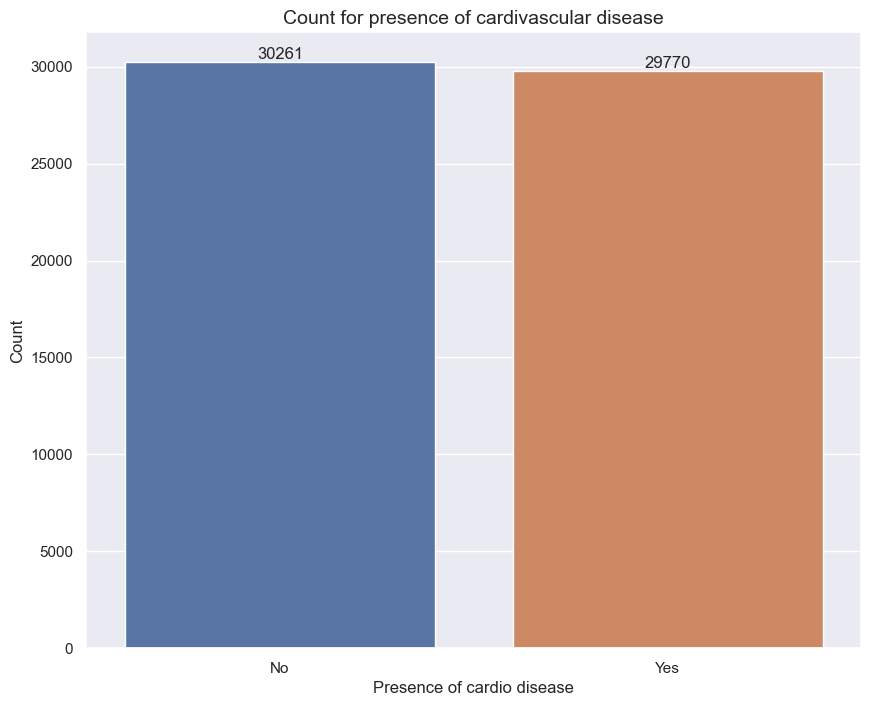

In [28]:
# Sets the plot size
plt.figure( figsize=(10,8) )

# Count each class of the target variable
ax = sns.countplot( x=df4['cardio'] )

# Set plot features
plt.title( 'Count for presence of cardivascular disease', fontsize=14 )
plt.xlabel( 'Presence of cardio disease' )
plt.ylabel( 'Count' )
plt.xticks( ticks=[0,1], labels=['No', 'Yes'] )

for i in ax.containers:
    ax.bar_label(i,)

plt.show()

- As we can see, the target variable is pretty much balanced

### Numerical Variables

In [29]:
# gets the numerical vars
numerical_vars = df4[['age','height','weight','ap_hi','ap_lo', 'imc', 'imc_diff']]

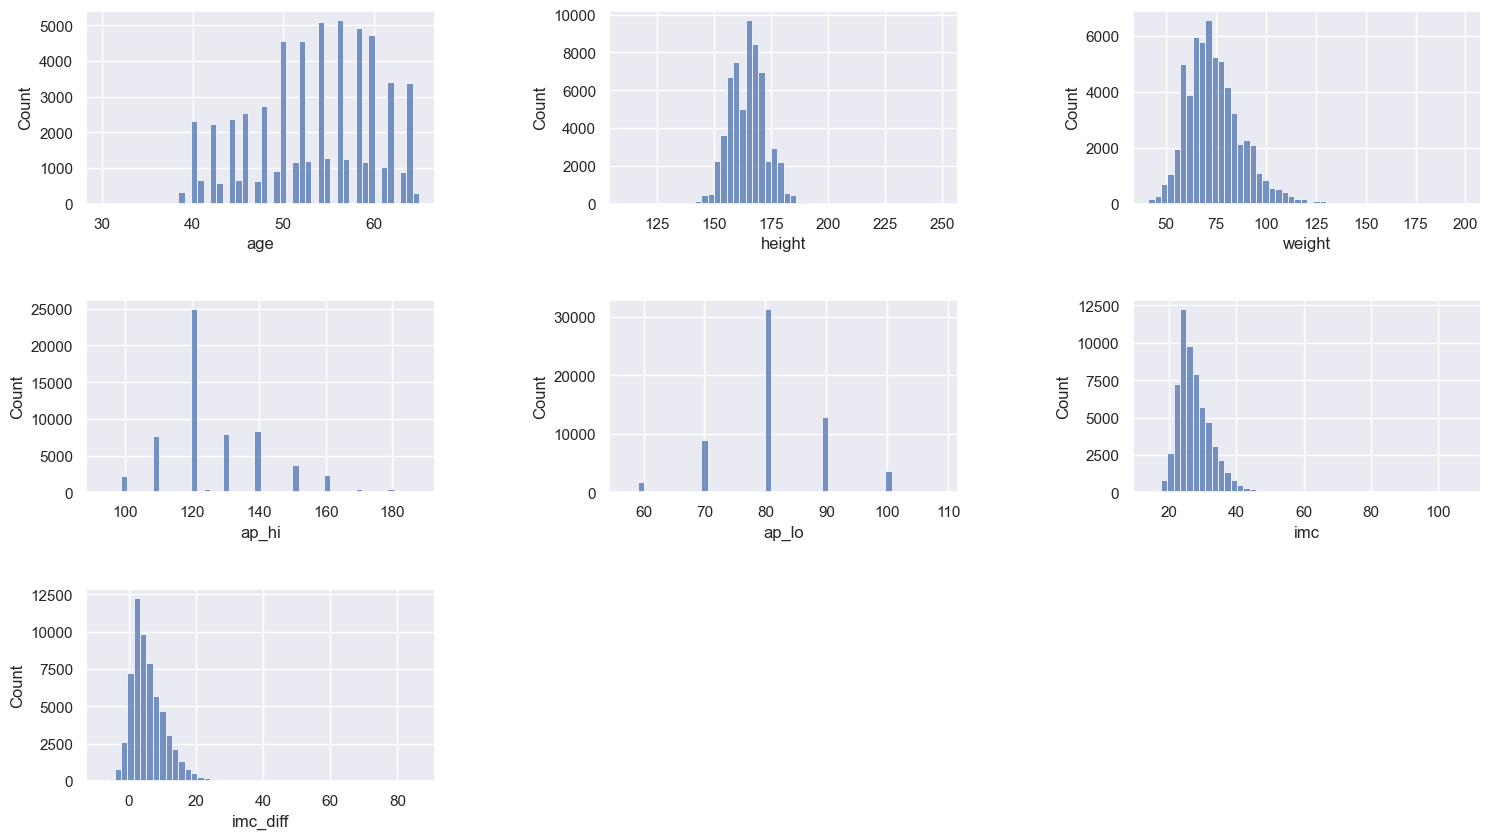

In [30]:
# Sets the plot size
plt.figure( figsize=( 18, 10 ) )

# sets the initial plot position
n = 1

# Iterates over the columns to plot
for columns in numerical_vars:
    plt.subplot( 3, 3, n )
    ax = sns.histplot( x=numerical_vars[columns], bins=50 )
    n += 1

# adjusts vertical space between plots
plt.subplots_adjust(hspace=0.5, wspace=0.5)   
    
plt.show()

**Observations**

- **Age** - Most pacients have ages between 50 and 60 years old.
- **Height** - Most between 1.60 and 1.70
- **Weight** - Between 60kg and 80kg
- **Pressures** - Presents a blood pressure of 120 for diastolic and 80 for sistolic which means elevated to high blood pressure.

### Categorical Variables

Because we don't have measurements, we'll consider the following variables as categorical:

- gender
- cholesterol
- gluc
- smoke
- alco
- active
- sobrepeso
- blood_pressure

In [31]:
 # gets the categorical vars
categorical_vars = df4[['gender','cholesterol','gluc','smoke','alco','active', 'sobrepeso', 'blood_pressure']]

In [32]:
# sets string categories for gender
categorical_vars['gender'] = categorical_vars['gender'].apply(lambda x: 'A' if x == 1 else 'B')

# converts gender to categorical dtype
categorical_vars['gender'] = categorical_vars['gender'].astype('category')


# sets string categories for glucose
categorical_vars['gluc'] = categorical_vars['gluc'].apply(lambda x: 'normal' if x == 1 
                                                                else 'above normal' if x == 2 
                                                                else 'well above normal')
# converts glucose to categorical dtype
categorical_vars['gluc'] = categorical_vars['gluc'].astype('category')


# sets string categories for cholesterol
categorical_vars['cholesterol'] = categorical_vars['cholesterol'].apply(lambda x: 'normal' if x == 1 
                                                                        else 'above normal' if x == 2 
                                                                        else 'well above normal')

# converts cholesterol to categorical dtype
categorical_vars['cholesterol'] = categorical_vars['cholesterol'].astype('category')


# sets string categories for smoke
categorical_vars['smoke'] = categorical_vars['smoke'].apply(lambda x: 'yes' if x == 1 else 'no')

# converts smoke to categorical dtype
categorical_vars['smoke'] = categorical_vars['smoke'].astype('category')


# sets string categories for alcohol intake
categorical_vars['alco'] = categorical_vars['alco'].apply(lambda x: 'yes' if x == 1 else 'no')

# converts alcohol intake to categorical dtype
categorical_vars['alco'] = categorical_vars['alco'].astype('category')


# sets string categories for active
categorical_vars['active'] = categorical_vars['active'].apply(lambda x: 'yes' if x == 1 else 'no')

# converts active to categorical dtype
categorical_vars['active'] = categorical_vars['active'].astype('category')

C:\Users\Pedro\AppData\Local\Temp\ipykernel_17308\3077576222.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorical_vars['gender'] = categorical_vars['gender'].apply(lambda x: 'A' if x == 1 else 'B')
C:\Users\Pedro\AppData\Local\Temp\ipykernel_17308\3077576222.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorical_vars['gender'] = categorical_vars['gender'].astype('category')
C:\Users\Pedro\AppData\Local\Temp\ipykernel_17308\3077576222.py:9: SettingWithCopyWarning: 
A value is trying to be

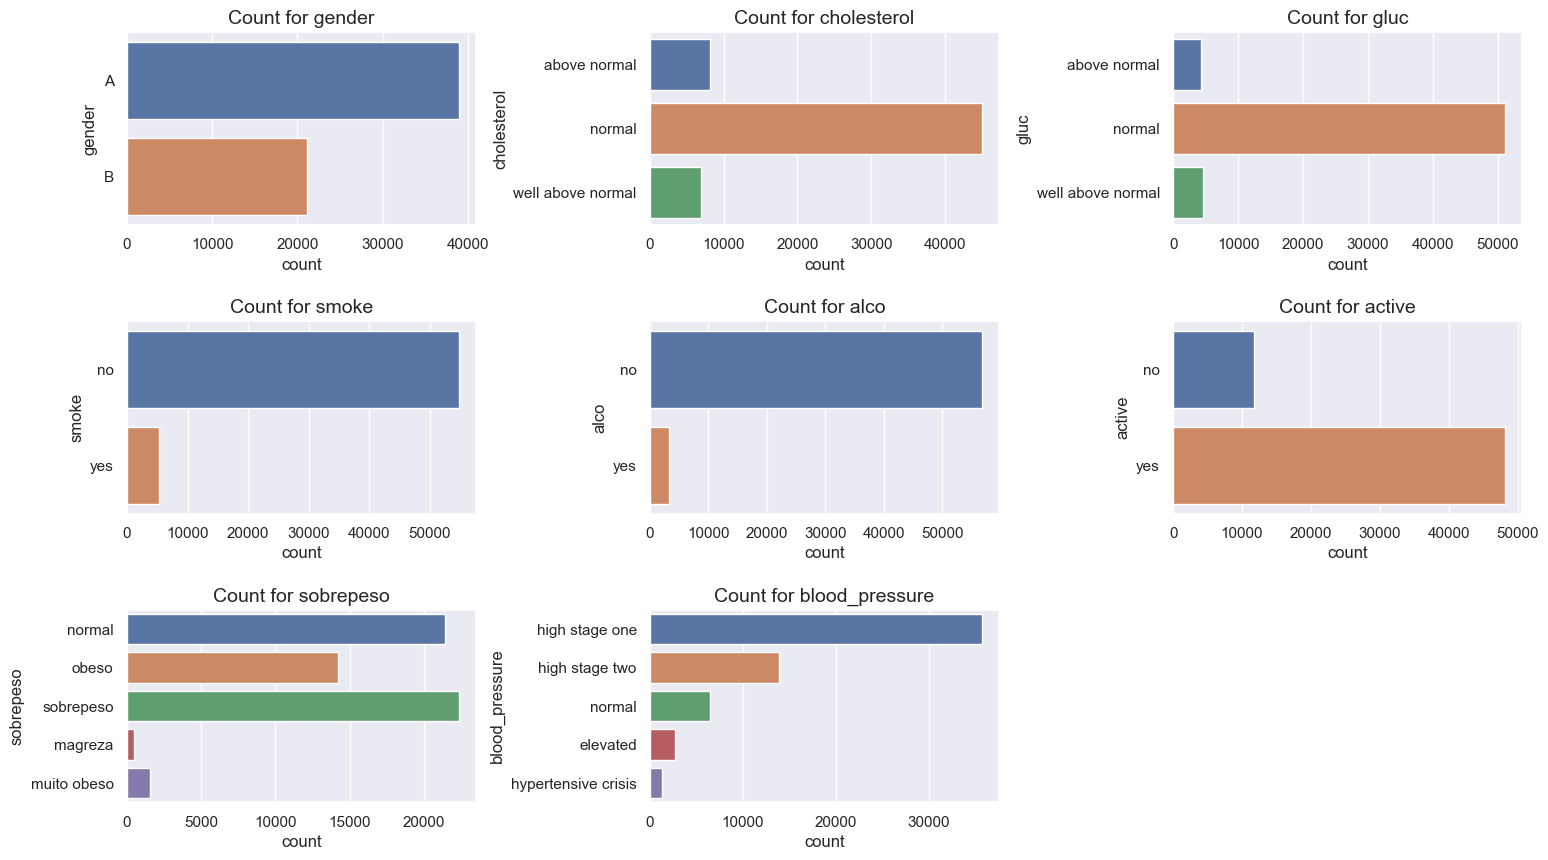

In [33]:
 # sets plot size
plt.figure(figsize=(18, 10))

# sets the inital plot position
n = 1

# iterates over the columns to plot
for column in categorical_vars.columns:
    plt.subplot(3, 3, n)
    ax = sns.countplot(y=categorical_vars[column])
    plt.title("Count for " + column, fontsize=14)
    n += 1

# adjust height and wdith reserved for space between subplots  
plt.subplots_adjust(hspace=0.5)
plt.subplots_adjust(wspace=0.5)

# display the plot
plt.show()

**Observations**

- There many more people presenting normal levels for both **cholesterol** and **glucose**.
- The great majority of people don't **smoke** neither intakes **alcohol**.
- The majority of people are physically **active**.

## 4.2. Bivariate Analysis

### 1. 50% das pessoas que fumam possuem doença cardiaca.
**Falso** - 46,59% das pessoas que fumam possuem doença cardiaca

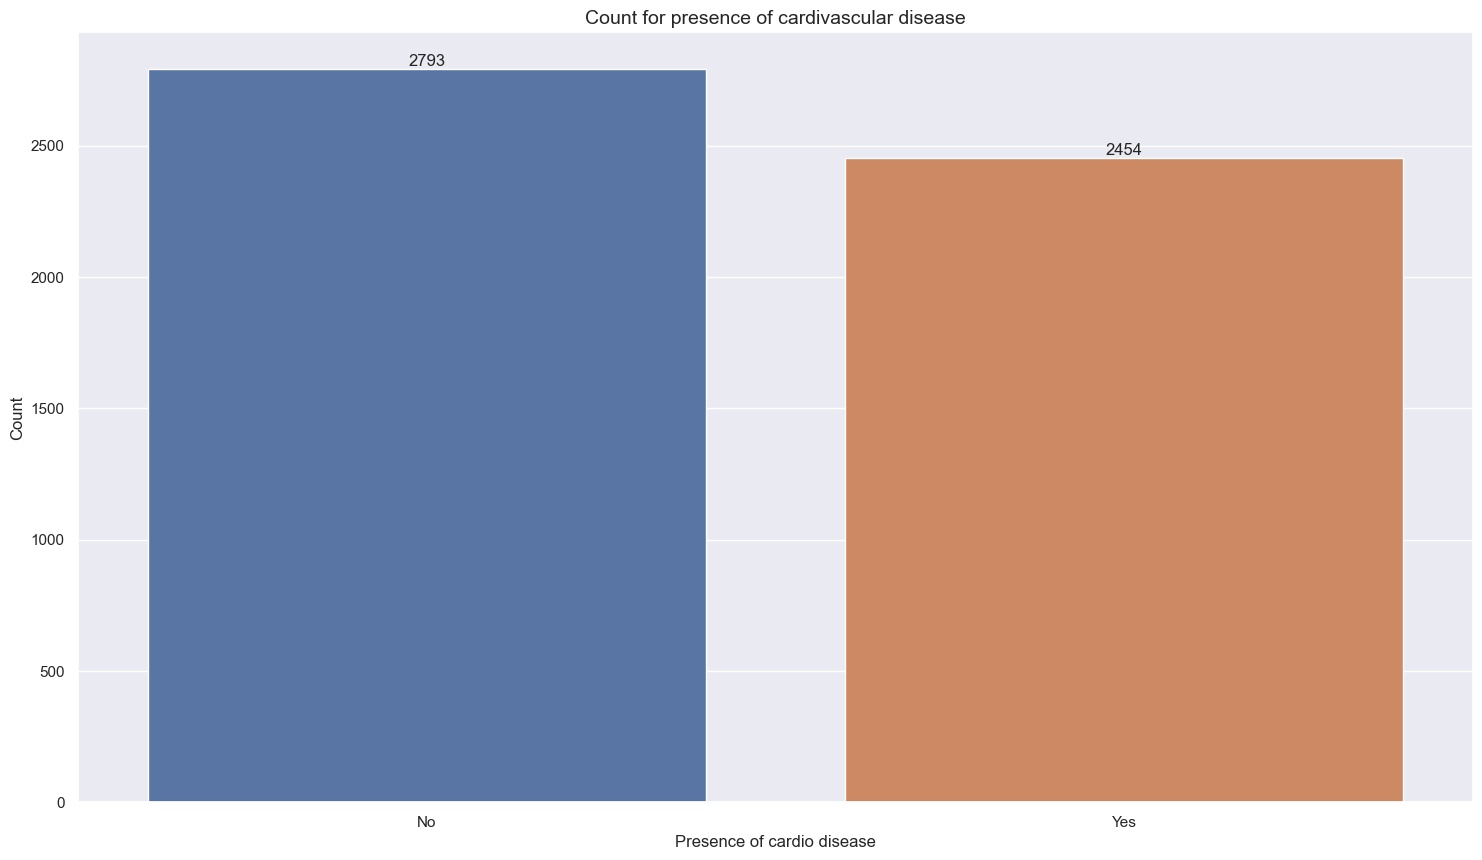

In [34]:
 # sets plot size
plt.figure(figsize=(18, 10))

aux = df4.loc[df4['smoke']== 1, :]

ax = sns.barplot( data=aux, x=aux['cardio'].unique(), y=aux['cardio'].value_counts() )

# Set plot features
plt.title( 'Count for presence of cardivascular disease', fontsize=14 )
plt.xlabel( 'Presence of cardio disease' )
plt.ylabel( 'Count' )
plt.xticks( ticks=[0,1], labels=['No', 'Yes'] )

for i in ax.containers:
    ax.bar_label( i, )

### 2. 80% das pessoas que praticam atividade fisica não possuem problemas cardiacos
**Falso**: Apenas 51,33% das pessoas que praticam exercicio não possuem problemas cardiacos

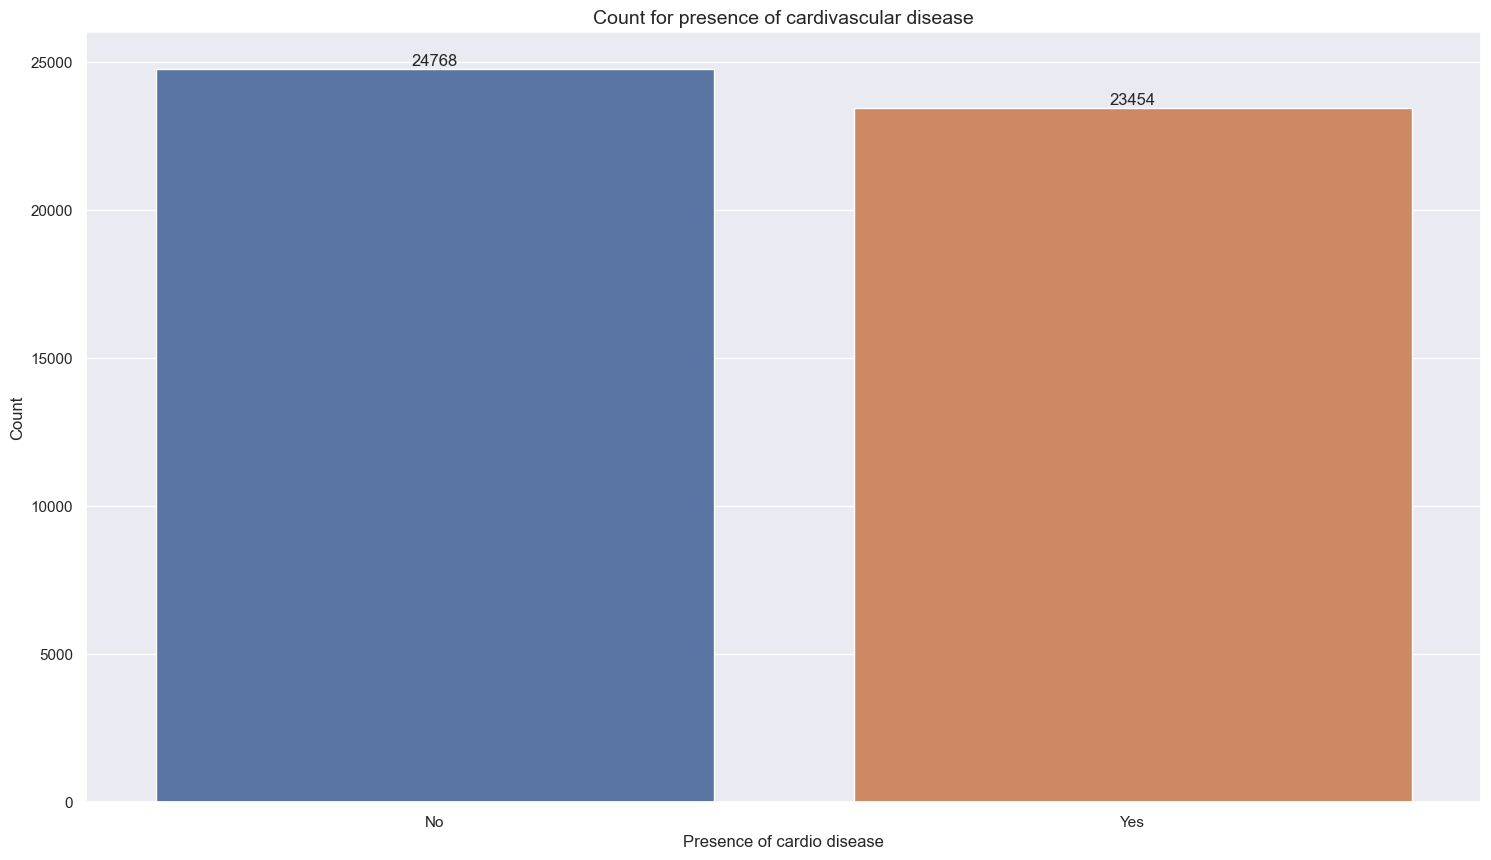

In [35]:
 # sets plot size
plt.figure(figsize=(18, 10))

aux = df4.loc[df4['active'] == 1, :]

ax = sns.barplot( data=aux, x=aux['cardio'].unique(), y=aux['cardio'].value_counts() )

# Set plot features
plt.title( 'Count for presence of cardivascular disease', fontsize=14 )
plt.xlabel( 'Presence of cardio disease' )
plt.ylabel( 'Count' )
plt.xticks( ticks=[0,1], labels=['No', 'Yes'] )

for i in ax.containers:
    ax.bar_label( i, )

### 3. Pessoas com imc elevado tendem a ter problemas cardiacos
**Verdadeiro**: Quanto maior o grau de sobrepeso, maior o numero proporcional de pessoas com problemas cardiacos

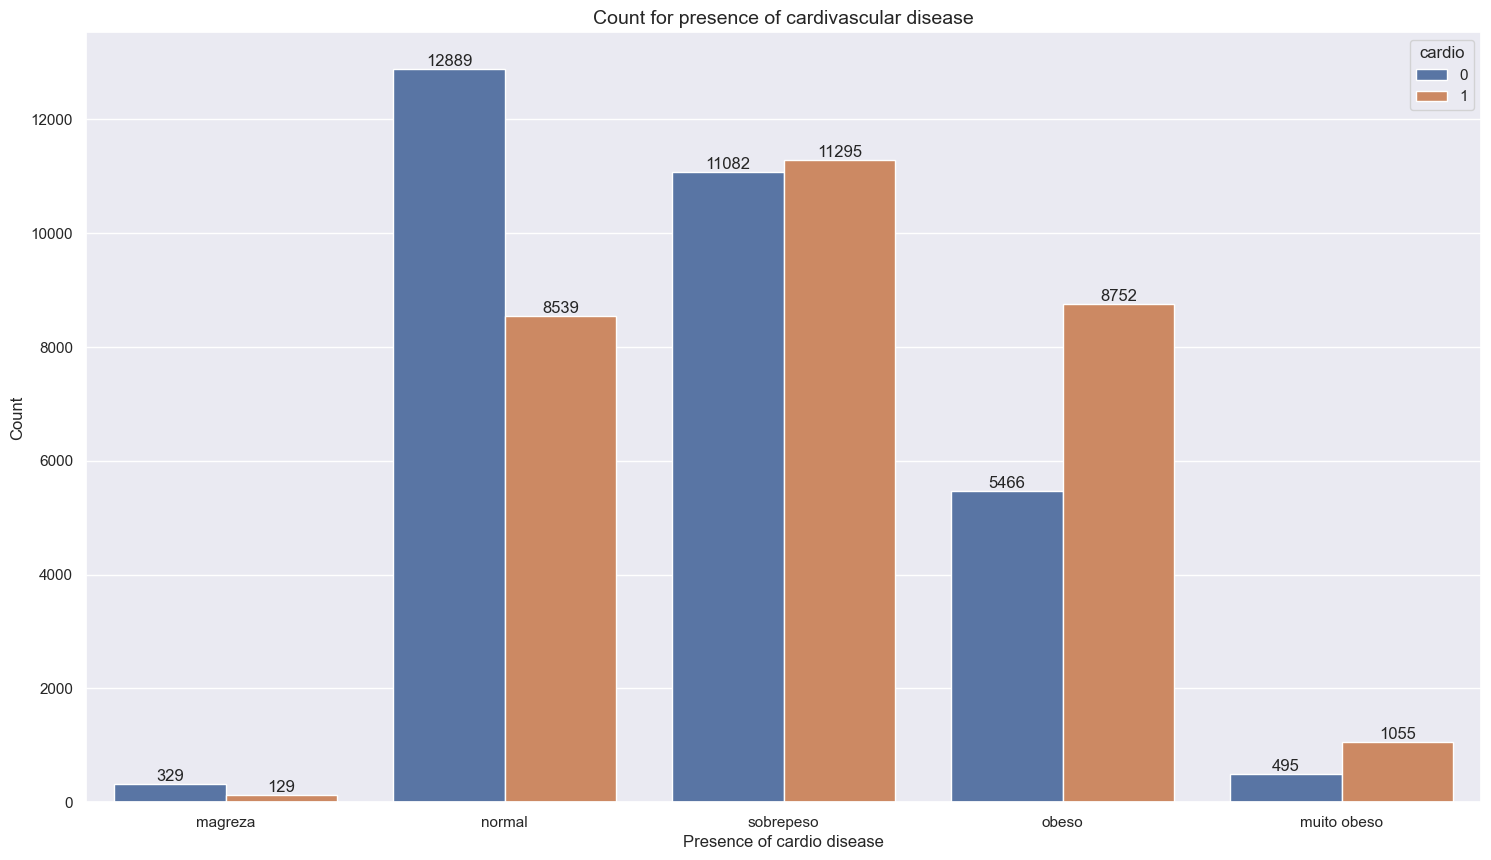

In [36]:
 # sets plot size
plt.figure(figsize=(18, 10))

custom_dict = { 'magreza': 0, 'normal': 1, 'sobrepeso': 2, 'obeso': 3, 'muito obeso': 4,  }

aux = df4[['sobrepeso', 'cardio', 'id' ]].groupby( ['sobrepeso', 'cardio'] ).count().reset_index().sort_values(by='sobrepeso', key= lambda x: x.map(custom_dict) )

ax = sns.barplot( data=aux, x='sobrepeso', y='id', hue='cardio' )

# Set plot features
plt.title( 'Count for presence of cardivascular disease', fontsize=14 )
plt.xlabel( 'Presence of cardio disease' )
plt.ylabel( 'Count' )

for i in ax.containers:
    ax.bar_label(i,)

### 4. Pessoas mais velhas tendem a ter problemas cardiacos.
**Verdadeiro**: Pessoas mais velhas tendem a ter problemas cardiacos (não há casos para pessoas com menos de 30 anos)

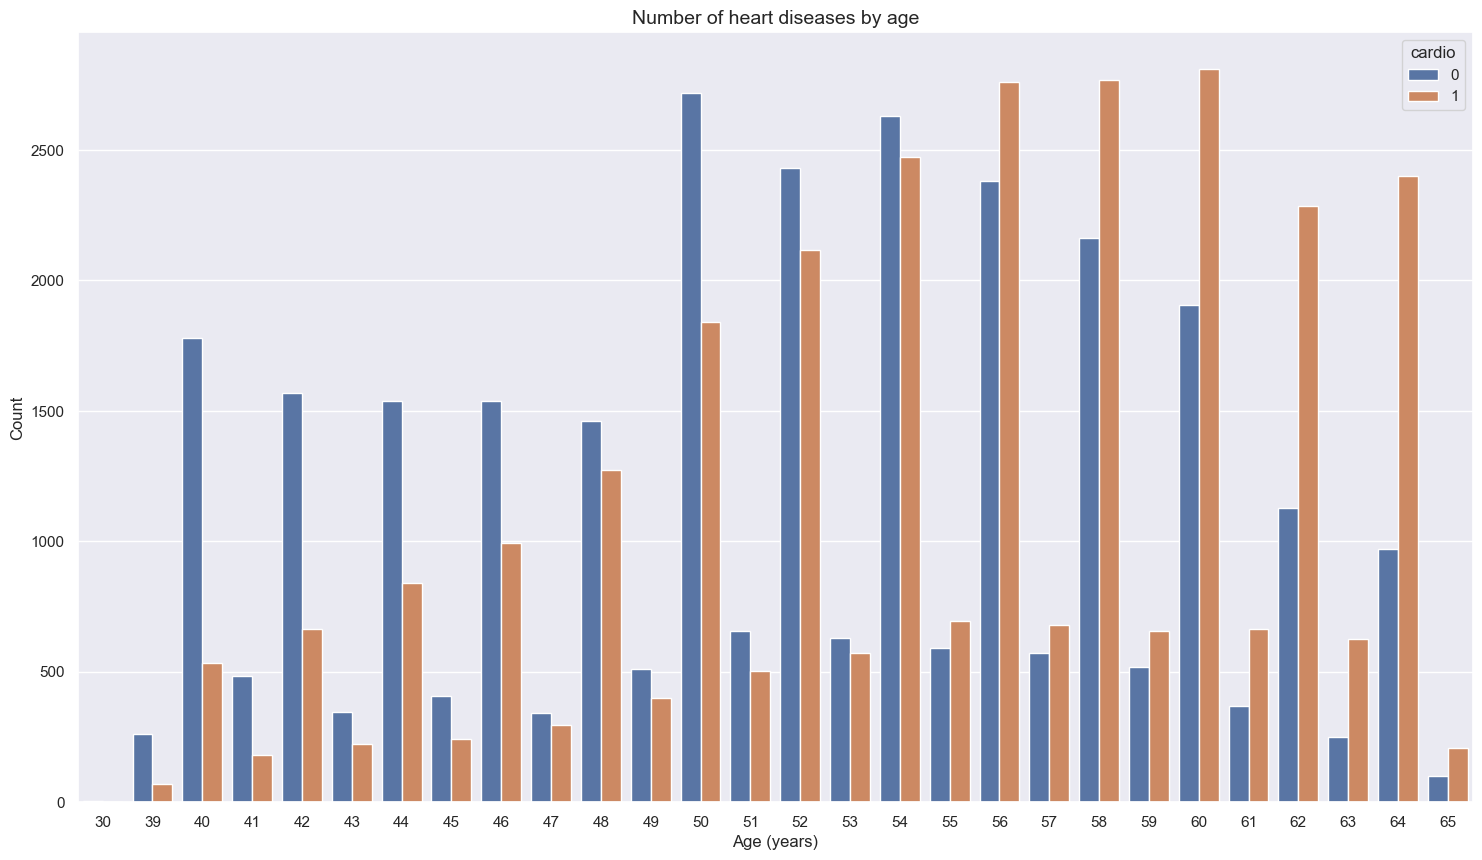

In [37]:
# sets plot size
plt.figure(figsize=(18,10))

# plots countplot
ax = sns.countplot(x='age', hue='cardio', data=df4)

# sets plot features
plt.title("Number of heart diseases by age", fontsize=14)
plt.xlabel("Age (years)")
plt.ylabel("Count")

# display plot
plt.show()

### 5. Pessoas com indice de colesterol mais altos tendem a ter problemas cardiacos.
**Verdadeiro**: A porcentagem de pessoas com problemas cardiacos quando o nivel de colesterol é alto é maior

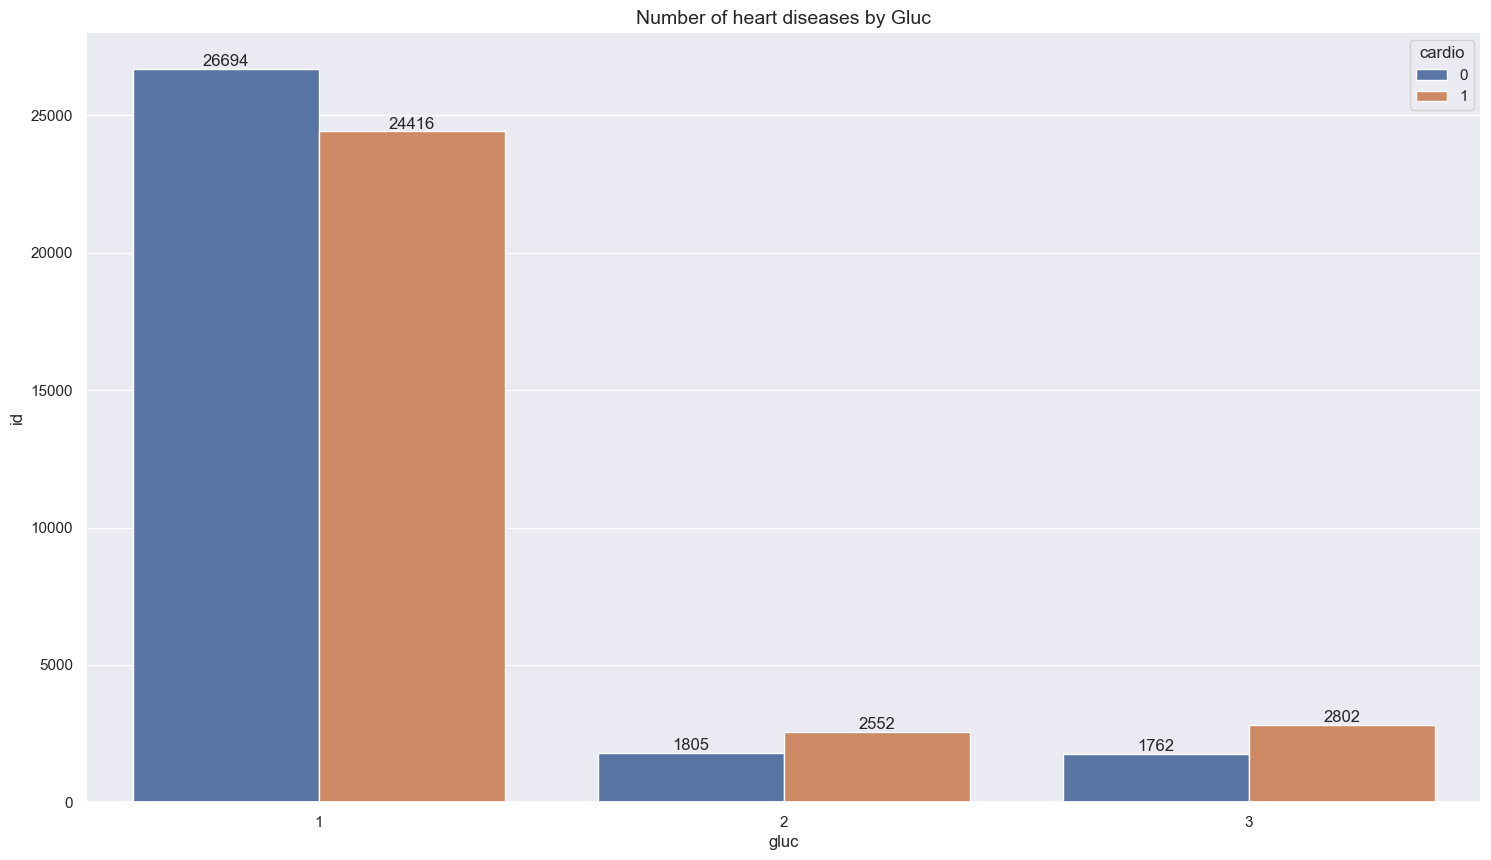

In [38]:
# sets plot size
plt.figure(figsize=(18,10))

aux = df4[['gluc', 'cardio', 'id' ]].groupby( ['gluc', 'cardio'] ).count().reset_index()

# sets plot features
plt.title("Number of heart diseases by Gluc", fontsize=14)
plt.xlabel("Gluc Situation)")
plt.ylabel("Count")

ax = sns.barplot( data=aux, x='gluc', y='id', hue='cardio' )
for i in ax.containers:
    ax.bar_label(i,)

## 4.3. Multivariated Analysis

Separating Dtypes of the Dataset, We'll consider:

**Numerical**

- Age
- Height
- Weight
- ap_hi
- ap_lo
- IMC
- IMC_diff

**Categorical**

- Gender
- Cholesterol
- Gluc
- Sobrepeso
- Blood Pressure

**Binary**

- Smoke
- Alco
- Active

**Target**

- Cardio

### Separating DTypes

In [39]:
# sets string categories for gender
df4.loc[:, 'gender'] = df4.loc[:,'gender'].apply(lambda x: 'A' if x == 1 else 'B')

# converts gender to categorical dtype
df4['gender'] = df4['gender'].astype('category')



# sets string categories for cholesterol
df4['cholesterol'] = df4['cholesterol'].apply(lambda x: 'normal' if x == 1 
                                             else 'above normal' if x == 2 
                                             else 'well above normal')

# converts cholesterol to categorical dtype
df4['cholesterol'] = df4['cholesterol'].astype('category')



# sets string categories for glucose
df4['gluc'] = df4['gluc'].apply(lambda x: 'normal' if x == 1 
                               else 'above normal' if x == 2 
                               else 'well above normal')

# converts glucose to categorical dtype
df4['gluc'] = df4['gluc'].astype('category')

In [40]:
 # gets only the numerical attributes
numerical_vars = df4[['age','height','weight','ap_hi','ap_lo', 'imc', 'imc_diff']]

# gets only the categorical attributes
categorical_vars = df4[['gender','cholesterol','gluc', 'sobrepeso', 'blood_pressure']]

# gets only the binary attributes
binary_vars = df4[['smoke','alco','active']]

### Numerical Correlation

C:\Users\Pedro\AppData\Local\Temp\ipykernel_17308\2513897909.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(correlations, dtype=np.bool))


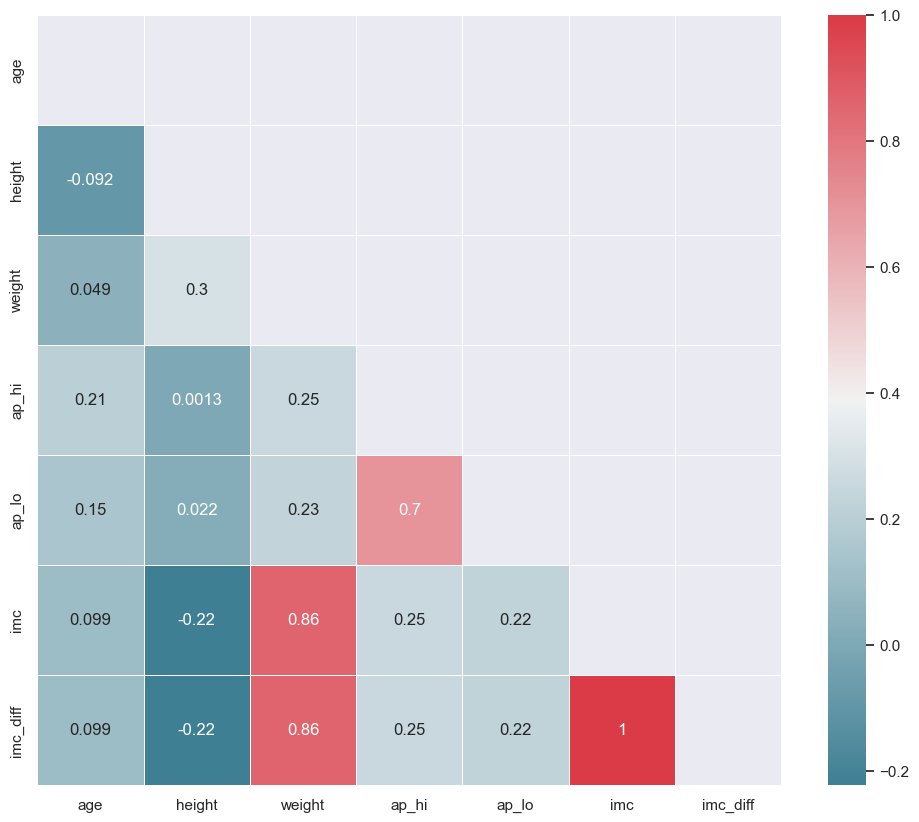

In [41]:
 # calcultes the correlations
correlations = numerical_vars.corr(method='pearson')

# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(12, 10)

# generates a mask for the upper triangle
mask = np.triu(np.ones_like(correlations, dtype=np.bool))

# generates a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# plots the heatmap
sns.heatmap(correlations, cmap=cmap, mask=mask, linewidths=.5, annot=True)

# displays the plot
plt.show()

### Correlation between categorical attributes

<AxesSubplot: >

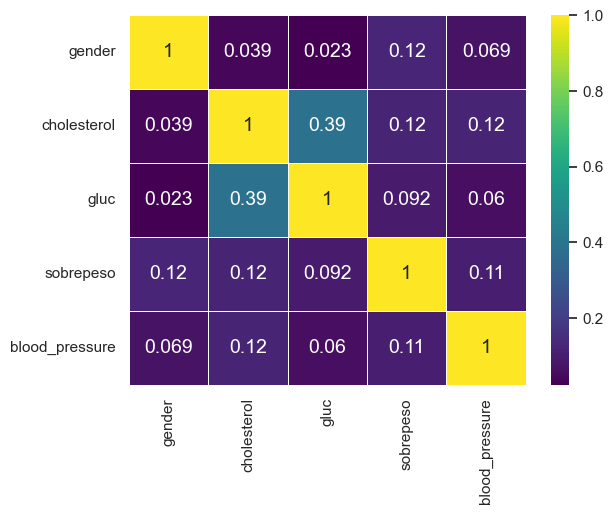

In [42]:
# Calculate cramer V
a1 = cramer_v( categorical_vars['gender'], categorical_vars['gender'] )
a2 = cramer_v( categorical_vars['gender'], categorical_vars['cholesterol'] )
a3 = cramer_v( categorical_vars['gender'], categorical_vars['gluc'] )
a4 = cramer_v( categorical_vars['gender'], categorical_vars['sobrepeso'] )
a5 = cramer_v( categorical_vars['gender'], categorical_vars['blood_pressure'] )

a6 = cramer_v( categorical_vars['cholesterol'], categorical_vars['gender'] )
a7 = cramer_v( categorical_vars['cholesterol'], categorical_vars['cholesterol'] )
a8 = cramer_v( categorical_vars['cholesterol'], categorical_vars['gluc'] )
a9 = cramer_v( categorical_vars['cholesterol'], categorical_vars['sobrepeso'] )
a10 = cramer_v( categorical_vars['cholesterol'], categorical_vars['blood_pressure'] )

a11 = cramer_v( categorical_vars['gluc'], categorical_vars['gender'] )
a12 = cramer_v( categorical_vars['gluc'], categorical_vars['cholesterol'] )
a13 = cramer_v( categorical_vars['gluc'], categorical_vars['gluc'] )
a14 = cramer_v( categorical_vars['gluc'], categorical_vars['sobrepeso'] )
a15 = cramer_v( categorical_vars['gluc'], categorical_vars['blood_pressure'] )

a16 = cramer_v( categorical_vars['sobrepeso'], categorical_vars['gender'] )
a17 = cramer_v( categorical_vars['sobrepeso'], categorical_vars['cholesterol'] )
a18 = cramer_v( categorical_vars['sobrepeso'], categorical_vars['gluc'] )
a19 = cramer_v( categorical_vars['sobrepeso'], categorical_vars['sobrepeso'] )
a20 = cramer_v( categorical_vars['sobrepeso'], categorical_vars['blood_pressure'] )

a21 = cramer_v( categorical_vars['blood_pressure'], categorical_vars['gender'] )
a22 = cramer_v( categorical_vars['blood_pressure'], categorical_vars['cholesterol'] )
a23 = cramer_v( categorical_vars['blood_pressure'], categorical_vars['gluc'] )
a24 = cramer_v( categorical_vars['blood_pressure'], categorical_vars['sobrepeso'] )
a25 = cramer_v( categorical_vars['blood_pressure'], categorical_vars['blood_pressure'] )


# Final dataset
d = pd.DataFrame( { 'gender':         [a1, a2, a3, a4, a5],
                    'cholesterol':    [a6, a7, a8, a9, a10],
                    'gluc':           [a11, a12, a13, a14, a15],
                    'sobrepeso':      [a16, a17, a18, a19, a20],
                    'blood_pressure': [a21, a22, a23, a24, a25]})


d = d.set_index( d.columns )

# sets the figure size in inches
ax.figure.set_size_inches(16, 6)



sns.heatmap( d, annot=True, linewidths=.5, annot_kws={"fontsize":14},cmap='viridis' )

# 5.0. Data Preparation

## Rules

**Distribuição normal e não possui outliers -> Standard Scaler**

**Distribuição normal e possui outliers -> Robust Scaler**

**Não distribuição normal -> Min Max Scaler**

**Testes:**

**QQ Plot** -> Quantile Quantile Plot (Quantile teorica x Quantile Real)

**KS Teste** -> Kolgomorv Smirnoff (Teste de Hipoteses) Se p-value > 0.5 -> Distribuição Normal, p-value < 0.5 -> Não distribuição normal

**Detecção de outiliers:**

**Box Plot:**

IRQ * 2.5 -> Acima desse valor é Outlier

Z-Score > 3 -> Outlier

Z-Score < -3 -> Outlier

In [43]:
df5 = df4.copy()
df5_aux = df4.copy()

## Spliting Train and Test Dataset

In [44]:
X = df5.drop(['cardio', 'id'], axis=1)
y = df5['cardio'].copy()

X_train, X_validation, y_train, y_validation = train_test_split( X, y, test_size=0.20, random_state=SEED )

## Scalling numerical atributes

In [45]:
 # separates the vars that will be scaled
train_vars_to_scale = X_train[['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'imc', 'imc_diff']]
validation_vars_to_scale = X_validation[['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'imc', 'imc_diff']]

In [46]:
# Standand Scaler
mm = pp.MinMaxScaler() 
ss = pp.StandardScaler()
rs = pp.RobustScaler()

In [47]:
 # scales the data
mm.fit(train_vars_to_scale)
train_numerical_scaled = mm.transform(train_vars_to_scale)
validation_numerical_scaled = mm.transform(validation_vars_to_scale)

In [48]:
 # converts scaled data to DataFrame for better readability
train_numerical_scaled = pd.DataFrame(train_numerical_scaled, columns=train_vars_to_scale.columns)
validation_numerical_scaled = pd.DataFrame(validation_numerical_scaled, columns=validation_vars_to_scale.columns) 

## Transformation

### Encoding Categorical Data

In [49]:
# gets categorical vars
train_categorical_vars = X_train[['gender']]
validation_categorical_vars = X_validation[['gender']]

# resets the index
train_categorical_vars.reset_index(drop=True, inplace=True)
validation_categorical_vars.reset_index(drop=True, inplace=True)

# one hot encoding
train_categorical_encoded = pd.get_dummies(train_categorical_vars, drop_first=False)
validation_categorical_encoded = pd.get_dummies(validation_categorical_vars, drop_first=False)

In [50]:
# As the binary vars are already encoded as 1s and 0s, there is no need to do the one-hot encoding
train_binary_vars = X_train[['smoke','alco','active']]
validation_binary_vars = X_validation[['smoke','alco','active']]

# resets index
train_binary_vars.reset_index(drop=True, inplace=True)
validation_binary_vars.reset_index(drop=True, inplace=True)

## Frequency Encoding Categorical Variables

In [51]:
X_train['cholesterol'].value_counts()

normal               36091
above normal          6495
well above normal     5438
Name: cholesterol, dtype: int64

In [52]:
X_train['gluc'].value_counts()

normal               40899
well above normal     3634
above normal          3491
Name: gluc, dtype: int64

In [53]:
X_train['sobrepeso'].value_counts()

sobrepeso      17905
normal         17176
obeso          11342
muito obeso     1226
magreza          375
Name: sobrepeso, dtype: int64

In [54]:
X_train['blood_pressure'].value_counts()

high stage one         28525
high stage two         11137
normal                  5177
elevated                2174
hypertensive crisis     1011
Name: blood_pressure, dtype: int64

In [55]:
# filters categorical attributes
train_cat_att_freq = X_train[['cholesterol','gluc','sobrepeso','blood_pressure']]

# resets the index
train_cat_att_freq.reset_index(drop=True, inplace=True)

In [56]:
# creates a dictionary from value counts
count_dict_cholesterol = train_cat_att_freq['cholesterol'].value_counts().to_dict()

# stores values as DataFrame
df_count_cholesterol = pd.DataFrame(count_dict_cholesterol.items(), columns=['Value','Count'])

# calculates the frequency for each value
df_count_cholesterol['frequency'] = df_count_cholesterol['Count'] / df_count_cholesterol['Count'].sum()


# creates a dictionary from value counts
count_dict_gluc = train_cat_att_freq['gluc'].value_counts().to_dict()

# stores values as DataFrame
df_count_gluc = pd.DataFrame(count_dict_gluc.items(), columns=['Value','Count'])

# calculates the frequency for each value
df_count_gluc['frequency'] = df_count_gluc['Count'] / df_count_gluc['Count'].sum()


# creates a dictionary from value counts
count_dict_weight_status = train_cat_att_freq['sobrepeso'].value_counts().to_dict()

# stores values as DataFrame
df_count_weight_status = pd.DataFrame(count_dict_weight_status.items(), columns=['Value','Count'])

# calculates the frequency for each value
df_count_weight_status['frequency'] = df_count_weight_status['Count'] / df_count_weight_status['Count'].sum()


# creates a dictionary from value counts
count_dict_blood_pressure = train_cat_att_freq['blood_pressure'].value_counts().to_dict()

# stores values as DataFrame
df_count_blood_pressure = pd.DataFrame(count_dict_blood_pressure.items(), columns=['Value','Count'])

# calculates the frequency for each value
df_count_blood_pressure['frequency'] = df_count_blood_pressure['Count'] / df_count_blood_pressure['Count'].sum()

In [57]:
# gets a dictionary for the frequency
frequency_cholesterol = df_count_cholesterol.set_index('Value').to_dict()['frequency']
frequency_gluc = df_count_gluc.set_index('Value').to_dict()['frequency']
frequency_weight_status = df_count_weight_status.set_index('Value').to_dict()['frequency']
frequency_blood_pressure = df_count_blood_pressure.set_index('Value').to_dict()['frequency']

In [58]:
 # creates an empty DataFrame
train_cat_attr_freq_encoded = pd.DataFrame()

# creates a columns for frequency
train_cat_attr_freq_encoded['cholesterol'] =  train_cat_att_freq['cholesterol'].map(frequency_cholesterol)
train_cat_attr_freq_encoded['gluc'] =  train_cat_att_freq['gluc'].map(frequency_gluc)
train_cat_attr_freq_encoded['sobrepeso'] =  train_cat_att_freq['sobrepeso'].map(frequency_weight_status)
train_cat_attr_freq_encoded['blood_pressure'] =  train_cat_att_freq['blood_pressure'].map(frequency_blood_pressure)

### Join All into a Dataset

In [59]:
 X_train_prep = pd.concat([train_numerical_scaled, train_binary_vars, train_categorical_encoded, train_cat_attr_freq_encoded], axis=1)

### Frequency Encoding Validation Data

In [60]:
 # filters categorical attributes
validation_cat_att_freq = X_validation[['cholesterol','gluc','sobrepeso','blood_pressure']]

# resets the index
validation_cat_att_freq.reset_index(drop=True, inplace=True)

In [61]:
# creates a dictionary from value counts
count_dict_cholesterol = validation_cat_att_freq['cholesterol'].value_counts().to_dict()

# stores values as DataFrame
df_count_cholesterol = pd.DataFrame(count_dict_cholesterol.items(), columns=['Value','Count'])

# calculates the frequency for each value
df_count_cholesterol['frequency'] = df_count_cholesterol['Count'] / df_count_cholesterol['Count'].sum()



# creates a dictionary from value counts
count_dict_gluc = validation_cat_att_freq['gluc'].value_counts().to_dict()

# stores values as DataFrame
df_count_gluc = pd.DataFrame(count_dict_gluc.items(), columns=['Value','Count'])

# calculates the frequency for each value
df_count_gluc['frequency'] = df_count_gluc['Count'] / df_count_gluc['Count'].sum()



# creates a dictionary from value counts
count_dict_weight_status = validation_cat_att_freq['sobrepeso'].value_counts().to_dict()

# stores values as DataFrame
df_count_weight_status = pd.DataFrame(count_dict_weight_status.items(), columns=['Value','Count'])

# calculates the frequency for each value
df_count_weight_status['frequency'] = df_count_weight_status['Count'] / df_count_weight_status['Count'].sum()



# creates a dictionary from value counts
count_dict_blood_pressure = validation_cat_att_freq['blood_pressure'].value_counts().to_dict()

# stores values as DataFrame
df_count_blood_pressure = pd.DataFrame(count_dict_blood_pressure.items(), columns=['Value','Count'])

# calculates the frequency for each value
df_count_blood_pressure['frequency'] = df_count_blood_pressure['Count'] / df_count_blood_pressure['Count'].sum()

In [62]:
 # gets a dictionary for the frequency
frequency_cholesterol = df_count_cholesterol.set_index('Value').to_dict()['frequency']
frequency_gluc = df_count_gluc.set_index('Value').to_dict()['frequency']
frequency_weight_status = df_count_weight_status.set_index('Value').to_dict()['frequency']
frequency_blood_pressure = df_count_blood_pressure.set_index('Value').to_dict()['frequency']

In [63]:
 # creates an empty DataFrame
validation_cat_attr_freq_encoded = pd.DataFrame()

# creates a columns for frequency
validation_cat_attr_freq_encoded['cholesterol'] =  validation_cat_att_freq['cholesterol'].map(frequency_cholesterol)
validation_cat_attr_freq_encoded['gluc'] =  validation_cat_att_freq['gluc'].map(frequency_gluc)
validation_cat_attr_freq_encoded['sobrepeso'] =  validation_cat_att_freq['sobrepeso'].map(frequency_weight_status)
validation_cat_attr_freq_encoded['blood_pressure'] =  validation_cat_att_freq['blood_pressure'].map(frequency_blood_pressure)

In [64]:
 # concatenates the data sets
X_validation_prep = pd.concat([validation_numerical_scaled, validation_binary_vars, validation_categorical_encoded, validation_cat_attr_freq_encoded], axis=1)

In [65]:
 # saves data set state
X_train_prep.to_csv('../data/processed/prep_train.csv', index=False)
X_validation_prep.to_csv('../data/processed/prep_validation.csv', index=False) 

## Teste de Reescala

In [66]:
df5.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio', 'imc',
       'imc_diff', 'sobrepeso', 'blood_pressure'],
      dtype='object')

In [67]:
variable = 'imc'

Min:13.76 - Max: 108.17


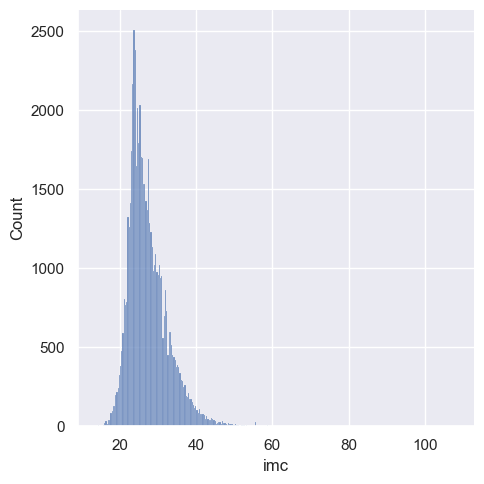

In [68]:
# Dados as IS
print( 'Min:{} - Max: {}'.format( df5_aux[variable].min(), df5_aux[variable].max() ) )
sns.displot(df5_aux[variable]);

Min:13.76 - Max: 108.17


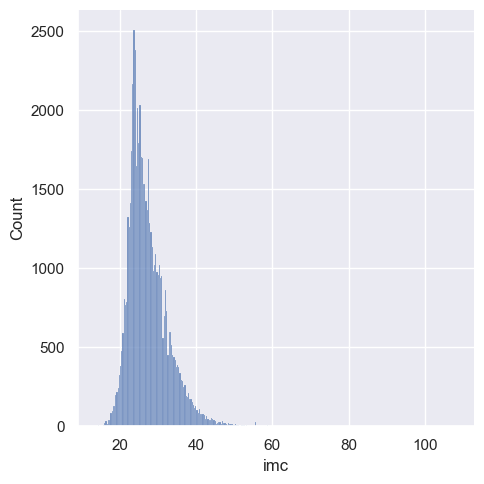

In [69]:
# Dados Normalizados ou Reescalados
print( 'Min:{} - Max: {}'.format( df5[variable].min(), df5[variable].max() ) )
sns.displot(df5[variable]);

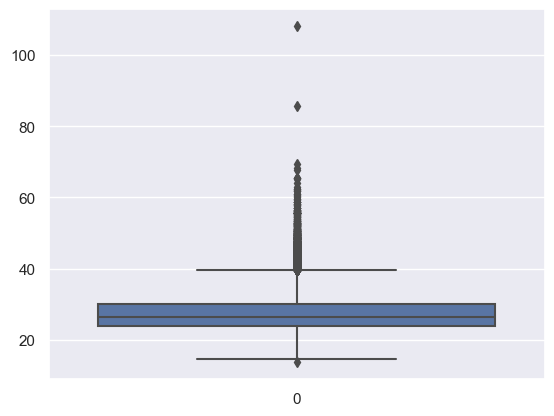

In [70]:
sns.boxplot( df5_aux[variable] );

# 6.0. Feature Selection

In [71]:
df6 = df5.copy()

In [72]:
# define RandomForestClassifier
# uses all cores from CPU
#rf_clf = RandomForestClassifier(n_jobs=-1)
#extra_clf = ExtraTreesClassifier(n_jobs=-1)

In [73]:
# define Boruta
# boruta = BorutaPy(extra_clf, n_estimators='auto', verbose=2, random_state=SEED).fit(X_train_prep.values, y_train.values.ravel())

In [74]:
# gets the ranked list of features
# cols_selected = boruta.support_.tolist()
# cols_selected_boruta = X_train_prep.iloc[:, cols_selected].columns.to_list()
# cols_selected_boruta

In [75]:
# creates data set with only the cols selected by boruta
# X_train_prep_boruta = X_train_prep[cols_selected_boruta].copy()
# X_validation_prep_boruta = X_validation_prep[cols_selected_boruta].copy()

In [76]:
# checking feature importances
# extra_clf.fit(X_train_prep, y_train)

# feat_importances = pd.Series(extra_clf.feature_importances_, index=X_train_prep.columns)
# feat_importances.sort_values().plot(kind='barh')

In [77]:
cols_selected = ['age', 'ap_hi', 'imc_diff', 'imc', 'height', 'weight', 'blood_pressure', 'cholesterol']

In [78]:
x_train = X_train_prep[ cols_selected ]
x_val = X_validation_prep [ cols_selected ]
y_val = y_validation.copy()

# 7.0. Model Selection

In [79]:
df7 = df6.copy()

## For Cross Validation

In [157]:
X_full = pd.concat([X_train_prep, X_validation_prep], axis=0)
y_full = pd.concat([y_train, y_validation], axis=0)

In [158]:
X_full.shape

(60031, 16)

## 7.1. KNN Model

In [103]:
# Model Definition
knn_model = nh.KNeighborsClassifier( n_neighbors=8 )

# Model Training
knn_model.fit( x_train, y_train )

# Model Prediction
yhat_knn = knn_model.predict( x_val )

# Metrics
knn_f1score = f1_score(y_val, yhat_knn)
knn_accuracy = accuracy_score( y_val, yhat_knn)
knn_recall = recall_score( y_val, yhat_knn, average='binary'  )
knn_precision = precision_score( y_val, yhat_knn )
knn_roc_auc = roc_auc_score( y_val, yhat_knn )


print('F1 Score: {}'.format(knn_f1score) )
print('Accuracy Score: {}'.format( knn_accuracy ) )
print('Recall Score: {} '.format( knn_recall ) )
print('Precision Score: {}'.format( knn_precision ) )
print('ROC_AUC Score: {}'.format( knn_roc_auc ) )

F1 Score: 0.6734109221128021
Accuracy Score: 0.6961772299491963
Recall Score: 0.6218584656084656 
Precision Score: 0.7342834830144475
ROC_AUC Score: 0.6967322198826016


### KNN Cross Validation

In [83]:
#knn_cv = cross_validation( 'KNN CV', knn_model, X_full, y_full )

## 7.2. Logistic Regression

In [108]:
# Model Definition
lr_model = lm.LogisticRegression( random_state=SEED )

# Model Training
lr_model.fit( x_train, y_train )

# Model Prediction
yhat_lr = lr_model.predict( x_val )

lr_f1score = f1_score(y_val, yhat_lr)
lr_accuracy = accuracy_score( y_val, yhat_lr)
lr_recall = recall_score( y_val, yhat_lr, average='binary'  )
lr_precision = precision_score( y_val, yhat_lr )
lr_roc_auc = roc_auc_score( y_val, yhat_lr )


print('F1 Score: {}'.format( lr_f1score) )
print('Accuracy Score: {}'.format( lr_accuracy ) )
print('Recall Score: {}'.format( lr_recall ) )
print('Precision Score: {}'.format( lr_precision ) )
print('ROC_AUC Score: {}'.format( lr_roc_auc ) )

F1 Score: 0.6962712467740502
Accuracy Score: 0.7157491463313067
Recall Score: 0.6468253968253969
Precision Score: 0.7539024860281365
ROC_AUC Score: 0.7162638479344302


### LR Cross Validation

In [85]:
#lr_cv = cross_validation( 'Logistic Regression CV', lr_model, X_full, y_full )

## 7.3. Extra Trees

In [86]:
# Model Definition
et_model = en.ExtraTreesClassifier( n_estimators=1000, n_jobs=-1, random_state=SEED )

# Model Training
et_model.fit( x_train, y_train )

# Model Prediction 
yhat_et = et_model.predict( x_val )

et_f1score = f1_score(y_val, yhat_et)
et_accuracy = accuracy_score( y_val, yhat_et)
et_recall = recall_score( y_validation, yhat_et, average='binary'  )
et_precision = precision_score( y_val, yhat_et )
et_roc_auc = roc_auc_score( y_val, yhat_et )


print('F1 Score: {}'.format( et_f1score) )
print('Accuracy Score: {}'.format( et_accuracy ) )
print('Recall Score: {}'.format( et_recall ) )
print('Precision Score: {}'.format( et_precision ) )
print('ROC_AUC Score: {}'.format( et_roc_auc ) )

F1 Score: 0.6761800219538968
Accuracy Score: 0.6806029815940702
Recall Score: 0.6620370370370371
Precision Score: 0.6909404659188956
ROC_AUC Score: 0.6807416264225293


### Extra Tress Cross Validation

In [87]:
#et_cv = cross_validation( 'Extra Trees CV', et_model, X_full, y_full )

## 7.4. Random Forest

In [88]:
# model definition
rf_model = en.RandomForestClassifier( n_estimators=1000, n_jobs=-1, random_state=SEED ) 

# model training
rf_model.fit( x_train, y_train )

# model prediction
yhat_rf = rf_model.predict( x_val )

rf_f1score = f1_score(y_validation, yhat_rf)
rf_accuracy = accuracy_score( y_val, yhat_rf)
rf_recall = recall_score( y_val, yhat_rf, average='binary' ) 
rf_precision = precision_score( y_val, yhat_rf )
rf_roc_auc = roc_auc_score( y_val, yhat_rf )

print ('F1 Score: {}'.format( rf_f1score ) )
print('Accuracy Score: {}'.format( rf_accuracy ) )
print('Recall Score: {}'.format( rf_recall ) )
print('Precision Score: {}'.format( rf_precision ) )
print('ROC_AUC Score: {}'.format( rf_roc_auc ) )

F1 Score: 0.6862447257383966
Accuracy Score: 0.6903472974098442
Recall Score: 0.6722883597883598
Precision Score: 0.7007928300586005
ROC_AUC Score: 0.6904821560646782


### Random Forest Cross Validation

In [89]:
#rf_cv = cross_validation( 'Random Forest CV', rf_model, X_full, y_full )

## 7.5. Light Gradient Boosting Machine

In [105]:
lgbm_model = LGBMClassifier()

lgbm_model.fit(x_train, y_train)

yhat_lgbm = lgbm_model.predict( x_val )


lgbm_f1score = f1_score(y_val, yhat_lgbm)
lgbm_accuracy = accuracy_score( y_val, yhat_lgbm)
lgbm_recall = recall_score( y_val, yhat_lgbm, average='binary' ) 
lgbm_precision = precision_score( y_val, yhat_lgbm )
lgbm_roc_auc = roc_auc_score( y_val, yhat_lgbm )

print('F1 Score: {}'.format( lgbm_f1score ) )
print('Accuracy Score: {}'.format( lgbm_accuracy ) )
print('Recall Score: {}'.format( lgbm_recall ) )
print('Precision Score: {}'.format( lgbm_precision ) )
print('ROC_AUC Score: {}'.format( lgbm_roc_auc ) )

F1 Score: 0.7012531328320801
Accuracy Score: 0.7021737319896727
Recall Score: 0.6939484126984127
Precision Score: 0.7087132725430598
ROC_AUC Score: 0.7022351561730024


### LGBM Cross Validation

In [91]:
#lgbm_cv = cross_validation( 'LGBM CV', lgbm_model, X_full, y_full )

## Results

In [92]:
results = {'Metric':['F1 Score', 'Accuracy Score', 'Recall Score', 'Precision Score', 'ROC_AUC Score'], 
           'KNN': [knn_f1score, knn_accuracy, knn_recall, knn_precision, knn_roc_auc], 
           'Logistic Regression': [lr_f1score, lr_accuracy, lr_recall, lr_precision, lr_roc_auc], 
           'Extra Trees': [et_f1score, et_accuracy, et_recall, et_precision, et_roc_auc], 
           'Random Forest': [rf_f1score, rf_accuracy, rf_recall, rf_precision, rf_roc_auc], 
           'LGBM': [lgbm_f1score, lgbm_accuracy, lgbm_recall, lgbm_precision, lgbm_roc_auc]}


df_results = pd.DataFrame( data=results).T

In [93]:
df_results.columns = df_results.iloc[0]
df_results =df_results[1:]


In [99]:
df_results.style.apply(highlight_max)

Metric,F1 Score,Accuracy Score,Recall Score,Precision Score,ROC_AUC Score
KNN,0.673411,0.696177,0.621858,0.734283,0.696732
Logistic Regression,0.696271,0.715749,0.646825,0.753902,0.716264
Extra Trees,0.676180,0.680603,0.662037,0.690940,0.680742
Random Forest,0.686245,0.690347,0.672288,0.700793,0.690482
LGBM,0.701253,0.702174,0.693948,0.708713,0.702235


## Cross Validation Results

In [95]:
#results_cv = pd.concat( [knn_cv, lr_cv, et_cv, rf_cv, lgbm_cv] )
#results_cv

## Confusion Matrix

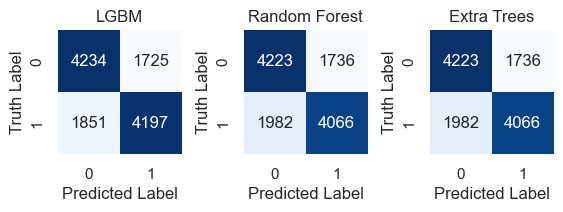

In [96]:
plt.subplot( 1, 3, 1 )
lgbm_matrix_confusion = confusion_matrix(y_val, yhat_lgbm)
sns.heatmap(lgbm_matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=False);
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.title('LGBM')


plt.subplot( 1, 3, 2 )
rf_matrix_confusion = confusion_matrix(y_val, yhat_rf)
sns.heatmap(rf_matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.title('Random Forest')


plt.subplot( 1, 3, 3 )
et_matrix_confusion = confusion_matrix(y_val, yhat_et)
sns.heatmap(rf_matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.title('Extra Trees')


# adjusts vertical space between plots
plt.subplots_adjust(hspace=0.5, wspace=0.5)  

- Aqui nós vamos escolher o modelo com o objetivo de reduzir o máximo possivel os Falsos Negativos, pois se trata de um problema de decteção de doenças. Logo, a melhor métrica para avaliarmos o modelo será a **Recall**

- Por outro lado, o negócio diz que o modelo será avaliado em cima da metrica de **Precision**, já que a cada 5% de aumento significa $500 a mais no pagamento do diagnóstico

- No caso, podemos utilizar o **F1 Score**, para ter uma balanço entre as outras duas métricas e por isso iremos escolher o modelo LGBM

In [145]:
lgbm_model.fit( x_train, y_train )
yhat_lgbm_prob = lgbm_model.predict_proba( x_val )[:, 1]
fpr_lgbm, tpr_lgbm, thresholds = roc_curve(y_val, yhat_lgbm_prob)
auc = roc_auc_score(y_val, yhat_lgbm_prob)

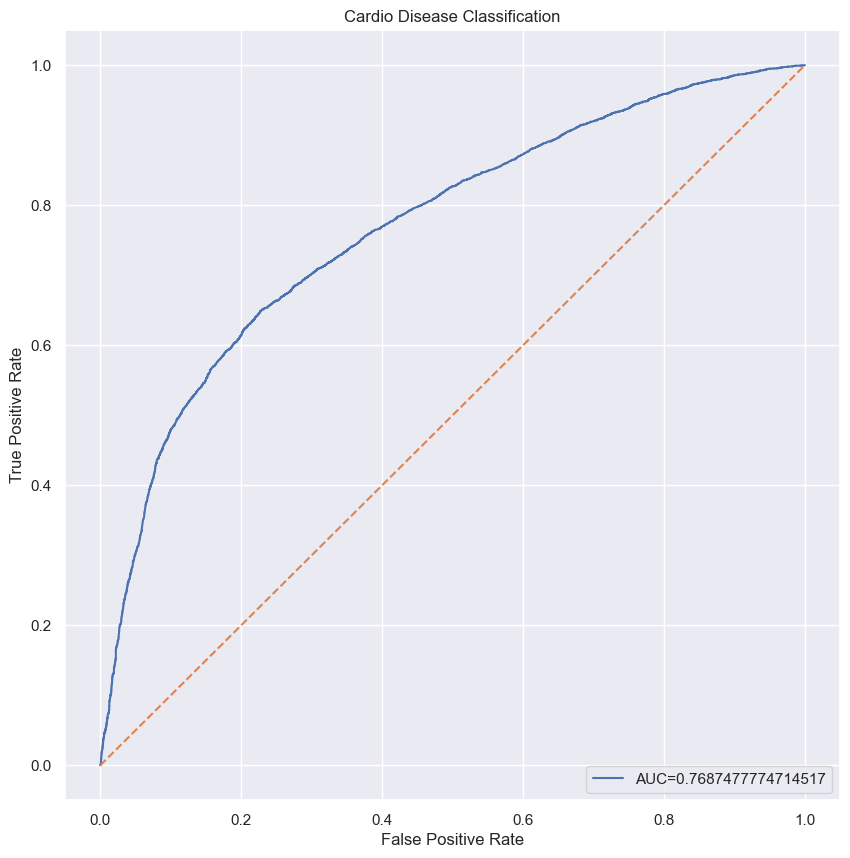

In [146]:
plt.subplots(1, figsize=(10,10))
plt.title('Cardio Disease Classification')
plt.plot(fpr_lgbm, tpr_lgbm, label="AUC="+str(auc))
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)

plt.show()

## Classification Report

In [112]:
ypred_lgbm = lgbm_model.predict( x_val )

print('Classification report for ' + type( lgbm_model ).__name__)
print( m.classification_report( y_val, ypred_lgbm ) )

Classification report for LGBMClassifier
              precision    recall  f1-score   support

           0       0.70      0.71      0.70      5959
           1       0.71      0.69      0.70      6048

    accuracy                           0.70     12007
   macro avg       0.70      0.70      0.70     12007
weighted avg       0.70      0.70      0.70     12007



# 8.0. Hyper-Parameter Fine Tuning

In [113]:
lgbm_model = LGBMClassifier( random_state=SEED, n_jobs=-1 )

In [131]:
dist = { 'max_depth': np.arange( 2, 12, 2 ),
         'num_leaves': 2 ** np.arange(2, 10, 1), 
         'min_data_in_leaf': np.arange( 100, 1050, 50 ),
         'learning_rate': np.linspace( 0.001, 0.6, 15 ),
         'colsample_bytree': np.linspace( 0.1, 1, 5  ),
         'subsample': np.linspace( 0.25, 1, 15 ),
         'n_estimators': np.arange( 10, 105, 15 )}

In [132]:
lgbm_model_cv = RandomizedSearchCV( estimator=lgbm_model, param_distributions=dist, scoring='f1',
                                    n_iter=100, cv=5, verbose=2, random_state=SEED, n_jobs=-1)

In [133]:
lgbm_model_cv.fit(x_train, np.ravel(y_train))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=LGBMClassifier(random_state=28), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': array([0.1  , 0.325, 0.55 , 0.775, 1.   ]),
                                        'learning_rate': array([0.001     , 0.04378571, 0.08657143, 0.12935714, 0.17214286,
       0.21492857, 0.25771429, 0.3005    , 0.34328571, 0.38607143,
       0.42885714, 0.47164286, 0.51442857, 0.55721429, 0.6       ]),
                                        'max_depth': arra...
                                        'min_data_in_leaf': array([ 100,  150,  200,  250,  300,  350,  400,  450,  500,  550,  600,
        650,  700,  750,  800,  850,  900,  950, 1000]),
                                        'n_estimators': array([ 10,  25,  40,  55,  70,  85, 100]),
                                        'num_leaves': array([  4,   8,  16,  32,  64, 128, 256, 512], dtype=int32),
                                        'subsample': array([0.25      , 0.30357143, 0.35714286, 0.41071429, 0.46428571,
       0.51785714, 0.57142857, 0.625     , 0.67857143, 0.73214286,
       0.78571429, 0.83928571, 0.89285714, 0.94642857, 1.        ])},
                   random_state=28, scoring='f1', verbose=2)

In [134]:
lgbm_model_cv.best_estimator_

LGBMClassifier(colsample_bytree=0.55, learning_rate=0.4288571428571428,
               max_depth=2, min_data_in_leaf=700, n_estimators=85, num_leaves=8,
               random_state=28, subsample=0.7857142857142857)

In [135]:
lgbm_tuned_model = lgbm_model_cv.best_estimator_

In [138]:
lgbm_tuned_model.fit(x_train, y_train)

yhat_lgbm_tuned = lgbm_tuned_model.predict( x_val )

lgbm_f1score = f1_score(y_val, yhat_lgbm_tuned)
lgbm_accuracy = accuracy_score( y_val, yhat_lgbm_tuned)
lgbm_recall = recall_score( y_val, yhat_lgbm_tuned, average='binary' ) 
lgbm_precision = precision_score( y_val, yhat_lgbm_tuned )
lgbm_roc_auc = roc_auc_score( y_val, yhat_lgbm_tuned )

print('F1 Score: {}'.format( lgbm_f1score ) )
print('Accuracy Score: {}'.format( lgbm_accuracy ) )
print('Recall Score: {}'.format( lgbm_recall ) )
print('Precision Score: {}'.format( lgbm_precision ) )
print('ROC_AUC Score: {}'.format( lgbm_roc_auc ) )

F1 Score: 0.7065643648763853
Accuracy Score: 0.7133338885650038
Recall Score: 0.6851851851851852
Precision Score: 0.7293206617388244
ROC_AUC Score: 0.7135440945224466


In [139]:
 # Print the tuned parameters and score
print("\nTuned Parameters: {}".format(lgbm_model_cv.best_params_)) 
print("\nBest score: {:.4f}".format(lgbm_model_cv.best_score_))


Tuned Parameters: {'subsample': 0.7857142857142857, 'num_leaves': 8, 'n_estimators': 85, 'min_data_in_leaf': 700, 'max_depth': 2, 'learning_rate': 0.4288571428571428, 'colsample_bytree': 0.55}

Best score: 0.7148


## ROC Curve

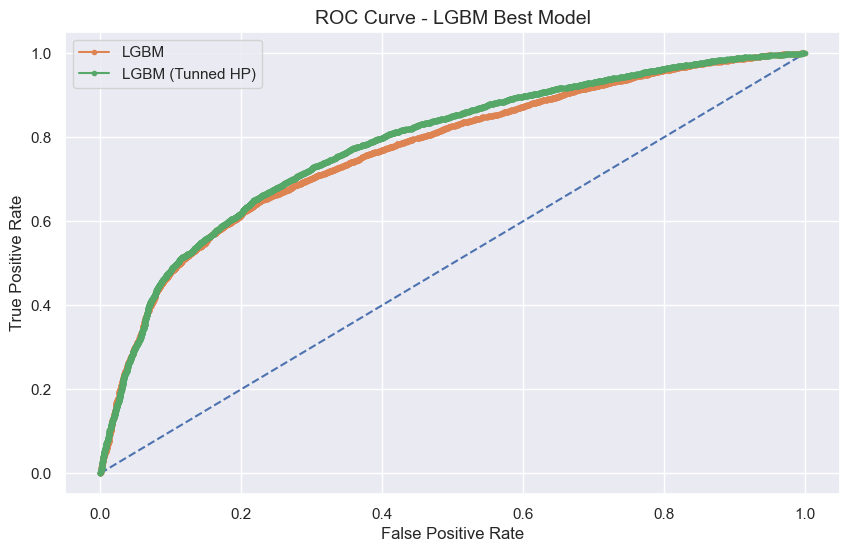

In [147]:
# sets the plot size
plt.figure(figsize=(10,6))
plt.plot([0, 1], ls="--")

# predict probabilities
lgbm_tuned_model_probs = lgbm_tuned_model.predict_proba(x_val)

# calculate roc curves
fpr_tuned, tpr_tuned, _ = roc_curve(y_val, lgbm_tuned_model_probs[:,1])

# plot the roc curve for the model
plt.plot(fpr_lgbm, tpr_lgbm, marker='.', label='LGBM')
plt.plot(fpr_tuned, tpr_tuned, marker='.', label='LGBM (Tunned HP)')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# title
plt.title('ROC Curve - LGBM Best Model', fontsize=14)

# show the legend
plt.legend()

# show the plot
plt.show()

Text(0.5, 1.0, 'LGBM')

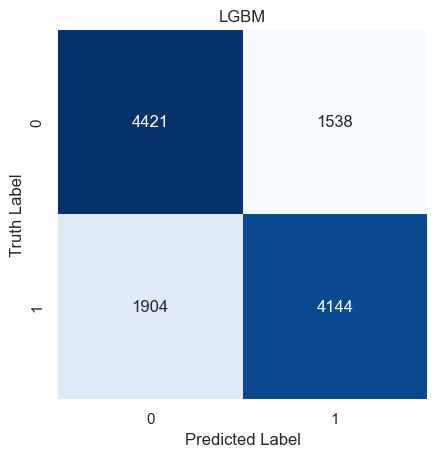

In [148]:
lgbm_matrix_confusion = confusion_matrix(y_val, yhat_lgbm_tuned)
sns.heatmap(lgbm_matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=False);
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.title('LGBM')

## Cross Validation Scoring

In [170]:
cross_validation( 'Tuned LGBM', lgbm_tuned_model, X_full, np.ravel(y_full) )

[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGB

,Accuracy Score,F1 Score,Recall Score,Precision Score,ROC_AUC Score
Tuned LGBM,0.73 +/- 0.004,0.721 +/- 0.006,0.703 +/- 0.033,0.741 +/- 0.021,0.796 +/- 0.002


## Business Results

In [177]:
price_per_percent = 500/5
baseline = 50
num_pacients = 70000

model_precision = 0.741
deviation = 0.021

precision_upper = (model_precision + deviation) * 100
precision_lower = (model_precision - deviation) * 100

percent_difference_upper = precision_upper - baseline
percent_difference_lower = precision_lower - baseline

amount_best = percent_difference_upper * price_per_percent * num_pacients
amount_worst = percent_difference_lower * price_per_percent * num_pacients

In [178]:
print(f'Best:  ${round(amount_best, 2):,.2f}')
print(f'Worst: ${round(amount_worst, 2):,.2f}')

Best:  $183,400,000.00
Worst: $154,000,000.00


## Saving Tuned Model

In [176]:
pickle.dump(lgbm_tuned_model, open( '../models/tuned_model.pkl', 'wb' ) )

# 9.0. Testing Model

In [179]:
df_test.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
12892,18380,19077,1,162,63.000000,120,80,1,1,0,0,1,0
42085,60105,21978,1,157,60.000000,120,80,1,1,0,0,1,1
24165,34527,20223,2,158,68.000000,120,70,1,1,1,1,1,1
7445,10612,22695,1,148,42.000000,120,80,1,1,0,0,1,1
69368,99086,16650,1,156,97.000000,135,90,3,3,0,0,1,1


## Criando as colunas

In [218]:
# Convertendo a coluna Age de dias para anos
df_test['age'] = round(df_test['age'] / 365)
df_test['age'] = df_test['age'].astype(np.int64)

# IMC
df_test['imc'] = round( df_test['weight'] / ( df_test['height'] ** 2 ) * 10000, 2 )

# Assuming the average of normal IMC is 21.7, lets calculate de difference
df_test['imc_diff'] = df_test['imc'] - 21.7

# Sobrepeso
df_test['sobrepeso'] = df_test['imc'].apply( lambda x: 'magreza' if x < 18.5 else 
                                   'normal' if ( 18.5 <= x < 24.9 ) else
                                   'sobrepeso' if ( 24.9 <= x < 29.9 ) else
                                   'obeso' if ( 29.9 <= x < 39.9 ) else 'muito obeso')


# calculates the blood pressures
df_test['blood_pressure'] = ['low' if (ap_hi <= 90) & (ap_lo <= 60)
                            else 'normal' if ((ap_hi > 90) & (ap_hi < 120)) & ((ap_lo > 60) & (ap_lo < 80))
                            else 'elevated' if ((ap_hi >= 120) & (ap_hi <= 120)) & (ap_lo < 80)
                            else 'high stage one' if ((ap_hi >= 130) & (ap_hi <= 139)) | ((ap_lo >= 80) & (ap_lo <=89))
                            else 'high stage two' if (ap_hi >= 140) | (ap_lo >= 90)
                            else 'hypertensive crisis'
                            for ap_hi, ap_lo in zip(df_test['ap_hi'], df_test['ap_lo'])]

## Aplicando as filtragens

In [219]:
# Removendo outliers da pressão sanguinea
df_test = df_test.loc[ (df_test['ap_hi'] < 190 ) & ( df_test['ap_hi'] > 90 ), :]
df_test = df_test.loc[ (df_test['ap_lo'] < 110 ) & ( df_test['ap_lo'] > 55 ), :]


# Removendo outliers da coluna Peso
df_test = df_test.loc[ df_test['weight'] > 40, : ]


# Removendo outliers da coluna altura
df_test = df_test.loc[ df_test['height'] > 110, : ]

## Variaveis Categóricas

In [220]:
# sets string categories for gender
df_test.loc[:, 'gender'] = df_test.loc[:,'gender'].apply(lambda x: 'A' if x == 1 else 'B')

# converts gender to categorical dtype
df_test['gender'] = df_test['gender'].astype('category')



# sets string categories for cholesterol
df_test['cholesterol'] = df_test['cholesterol'].apply(lambda x: 'normal' if x == 1 
                                             else 'above normal' if x == 2 
                                             else 'well above normal')

# converts cholesterol to categorical dtype
df_test['cholesterol'] = df_test['cholesterol'].astype('category')



# sets string categories for glucose
df_test['gluc'] = df_test['gluc'].apply(lambda x: 'normal' if x == 1 
                               else 'above normal' if x == 2 
                               else 'well above normal')

# converts glucose to categorical dtype
df_test['gluc'] = df_test['gluc'].astype('category')

## Separando df_test

In [221]:
x_test = df_test.drop(columns=['id', 'cardio'], axis=1)
y_test = df_test['cardio']

## Transformações e Encodings

In [222]:
x_test['age'] = mm.fit_transform( x_test[['age']] )
x_test['height'] = mm.fit_transform( x_test[['height']] )
x_test['weight'] = mm.fit_transform( x_test[['weight']] )
x_test['ap_hi'] = mm.fit_transform( x_test[['ap_hi']] )
x_test['ap_lo'] = mm.fit_transform( x_test[['ap_lo']] )
x_test['imc'] = mm.fit_transform( x_test[['imc']] )
x_test['imc_diff'] = mm.fit_transform( x_test[['imc_diff']] )

In [223]:
x_test = pd.get_dummies( x_test, columns=['gender']  )

In [224]:
cat_var = ['cholesterol', 'gluc', 'sobrepeso', 'blood_pressure']

In [232]:
encoder_dictionary = {}
for var in cat_var:
    encoder_dictionary[var] = ( x_test[var].value_counts()/len(x_test) ).to_dict()

In [235]:
for var in cat_var:
    x_test[var] = x_test[var].map(encoder_dictionary[var])

## Perfomance de Generalização

In [237]:
x_test = x_test[ cols_selected ]

In [241]:
yhat_test = lgbm_tuned_model.predict( x_test )


lgbm_test_f1score = f1_score(y_test, yhat_test)
lgbm_test_accuracy = accuracy_score( y_test, yhat_test)
lgbm_test_recall = recall_score( y_test, yhat_test, average='binary' ) 
lgbm_test_precision = precision_score( y_test, yhat_test )
lgbm_test_roc_auc = roc_auc_score( y_test, yhat_test )

print('F1 Score: {}'.format( lgbm_test_f1score ) )
print('Accuracy Score: {}'.format( lgbm_test_accuracy ) )
print('Recall Score: {}'.format( lgbm_test_recall ) )
print('Precision Score: {}'.format( lgbm_test_precision ) )
print('ROC_AUC Score: {}'.format( lgbm_test_roc_auc ) )

F1 Score: 0.6918936551949111
Accuracy Score: 0.7169613425232244
Recall Score: 0.638855421686747
Precision Score: 0.7545357524012807
ROC_AUC Score: 0.7165654568183288


# 10.0. Business Performance

Remembering the price of the diagnosis paid by the client, it varies according to the precision achieved by the specialists


| Exam Precision   |      Price      |  Example |
|:----------|:-------------|:------|
| Above 50% |\+\$500 for each additional 5% precision | Precision = 60% -> $1,000.00 |

Our full dataset has 70.000 clients. Assuming that all clients in the database went to the clinic to make a diagnosis, using our model which has an accuracy ranging from 72% - 76%, the value of all diagnoses compared to the current model would be:


| Models   |      Best      |  Worst |
|:----------|:-------------|:------|
| Our Model | \$183,400,000.00 | \$154,000,000.00 |
| Current   | \$105,000,000.00 | \$35,000,000.00 |

**Conclusion**

- Our model guarantees an accuracy of around 75%, which means a best case profit of $148,400,000.00